## This notebook implements KNN(K Nearest Neighbor) Classifier algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

#### 2-D matrix input data consisting of 100 synthetic samples to + even split of binary class labels as last column
| dim1 | dim2 | label |
|------|------|-------|
|x11|x12|y1|
|x21|x22|y2|
|  ... |  ... |  ...  | 
|x1001|x1002|y100|

In [2]:
number_of_synthetic_samples = 100

#### class 0's dimension 1 to be drawn from Guassian distribution with mean of -2 & standard deviation of 2, assume half of sample size is labeled class 0

In [3]:
dim1_class0_input = np.random.normal(loc=-2.0, scale=2.0, size=number_of_synthetic_samples//2)
dim1_class0_input.shape

(50,)

#### class 1's dimension 1 to be drawn from Guassian distribution with mean of +2 & standard deviation of 2, assume half of sample size is labeled class 1

In [4]:
dim1_class1_input = np.random.normal(loc=2.0, scale=2.0, size=number_of_synthetic_samples//2)
dim1_class1_input.shape

(50,)

#### dim1 column = (dim1_class0 (50 samples w specified population parameters of dim1_class0) + dim1_class1 (50 samples w specified population parameters of dim1_class1))

In [5]:
all_dim1_input = np.concatenate((dim1_class0_input, dim1_class1_input,), axis=0)
all_dim1_input.shape

(100,)

#### class 0's & class 1's dimension 2 are both to be drawn from Normal dist. with mean of 0 & and standard deviation of 1

In [10]:
all_dim2_input = np.random.normal(loc=0.0, scale=1.0, size=number_of_synthetic_samples)
all_dim2_input.shape

(100,)

#### since dim1 column = dim1_class0 (50 samples w specified population parameters of dim1_class0) + dim1_class1 (50 samples w specified population parameters of dim1_class1), 1st 50 must be labeled 0 & 2nd 50 labeled 1

In [13]:
class0_labels = [0]*(number_of_synthetic_samples//2)
class1_labels = [1]*(number_of_synthetic_samples//2)
all_labels = class0_labels+class1_labels
print(f'1st 50 labels:{all_labels[:50]}\n2nd 50 labels:{all_labels[50:]}')

1st 50 labels:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2nd 50 labels:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### turn matrix into dataframe with 100 rows (observations) & 2+1 columns, 2(features/dimensions) + 1(labels)

In [8]:
df = pd.DataFrame({'dim1':all_dim1_input, 'dim2': all_dim2_input, 'labels':all_labels}, columns=['dim1','dim2','labels'])
df.head()

,dim1,dim2,labels
0,-1.006572,-1.415371,0
1,-2.276529,-0.420645,0
2,-0.704623,-0.342715,0
3,1.046060,-0.802277,0
4,-2.468307,-0.161286,0


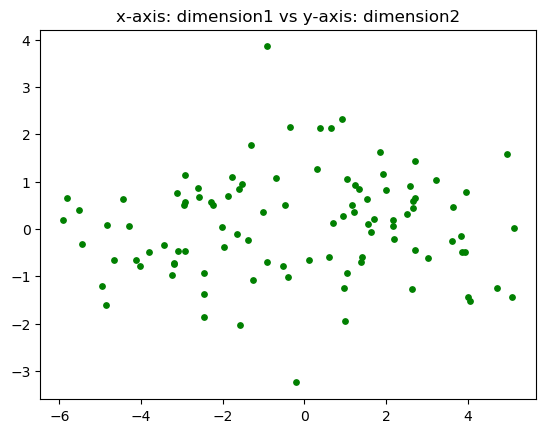

In [23]:
plt.scatter(x=all_dim1_input, y=all_dim2_input, s=15, c='g')
plt.title('x-axis: dimension1 vs y-axis: dimension2')

#### dimension1 data points are more disperesed, making data more separable for classification and pattern recignition

Text(0.5, 1.0, 'x-axis: dimension1 vs y-axis: labels')

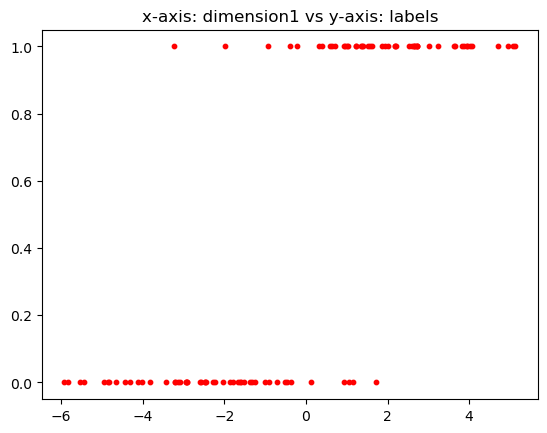

In [24]:
plt.scatter(x=all_dim1_input, y=all_labels, s=10, c='r')
plt.title('x-axis: dimension1 vs y-axis: labels')

#### dimension2 data points are not disperesed or separable, neither of two impose a clear pattern for classifier

Text(0.5, 1.0, 'x-axis: dimension2 vs y-axis: labels')

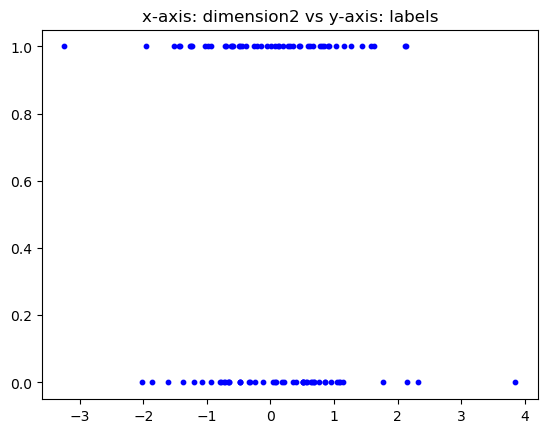

In [26]:
plt.scatter(x=all_dim2_input, y=all_labels, s=10, c='b')
plt.title('x-axis: dimension2 vs y-axis: labels')